We simulated data to find out how PAC arises with different parameters, and how the parameters affect each other.

    1) Simulate sinusoid
    2) 'Roll' sinusoid to not have same phase every time
    2) Add brown noise
    3) For each cycle, create (a wider or more narrow - or a uniform) distribution from which samples are taken to define the location of HF activity
    4) For each HF activity (100 per cycle) simulate a sinusoid (80-250Hz) and add to cycle of signal
    5) use FOOOF, ByCycle, and measure PAC


For each signal parameters are randomly chosen from these options:

    1) Frequency:           [10]                      Hz  
    
Ideally, we would pick a random number between 4 and 24 Hz as LF, but not possible with current ByCycle yet

    2) Brown noise slope:   [-2 : -1.5]               Exp
    
We cannot to up to -3 exp for brown noise, because there not enough power in the PSD and will be highly effected by adding HF's 

    3) Firing distribution  [.05 - .29 & uniform]   The STD of distributioin 0-1 with mean .5
    4) HF activity          [80 : 250]              Hz
    
In the end, we have four groups:

    1) Sinusoids + (more or less) phase-locked HF activity 
    2) Nonsinusoids + (more or less) phase locked HF activity
    3) Sinusoids + uniform HF activity
    4) Nonsinusoids + uniform HF activity

What we expect:

    1) In group 3 we expect the least PAC and least correlations between PAC and shape and PSD measures. 
    2) In group 2 might be highest PAC, but possibly only if the rdsym of nonsinusoids lines up with the HF activity (so maybe only just some channels with really high PAC
    3) In both group 1 and group 4 we expect PAC and their interactions with shape. This would imply that PAC & shape can be caused by both nonsinusoidal waveform shape, and HF activity (that will also alter nonsinusoidal waveform shape).


In [237]:
import os 
import numpy as np
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import linear_model

import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)


In [246]:
# Set directory in which the data structure can be found
os.chdir(r'C:\Users\jaapv\Desktop\master\VoytekLab')

# data
simulation_features_full = pd.read_csv('simulation_features_2_0_1.csv', sep=',')
simulation_features_full = simulation_features_full.dropna()

In [247]:
# create absolute values for symmetry measures
simulation_features_full['rdsym_abs'] = abs(simulation_features_full['rdsym'] - .5)
simulation_features_full['ptsym_abs'] = abs(simulation_features_full['ptsym'] - .5)
simulation_features_full['asine_rdsym'] = abs(simulation_features_full['asine_rdsym'] - .5)

In [248]:
# create two groups: sine and asine
simulation_features_sine =  simulation_features_full[(simulation_features_full['asine_rdsym']==0)]
simulation_features_asine = simulation_features_full[(simulation_features_full['asine_rdsym']!=0)]

# create four groups - split in uniform and phaselocked
simulation_features_sine_std = simulation_features_full[(simulation_features_full['asine_rdsym']==0) &
                                                        (simulation_features_full['firing_std'] !=1)]
simulation_features_asine_std = simulation_features_full[(simulation_features_full['asine_rdsym']!=0) &
                                                        (simulation_features_full['firing_std'] !=1)]
simulation_features_sine_uni = simulation_features_full[(simulation_features_full['asine_rdsym']==0) &
                                                       (simulation_features_full['firing_std']==1)]
simulation_features_asine_uni = simulation_features_full[(simulation_features_full['asine_rdsym']!=0) &
                                                       (simulation_features_full['firing_std']==1)]

group_name = ['sinusoids with phase-coupled HFs', 'nonsinusoids with phase-coupled HFs',
             'sinusoids with uniform HFs', 'nonsinusoids with uniform HFs']

In [249]:
# list for sine/asine
sine_or_asine = [simulation_features_sine, simulation_features_asine]

# list for four groups
simulation_features_list = [simulation_features_sine_std, simulation_features_asine_std,
                       simulation_features_sine_uni, simulation_features_asine_uni]

# Percent of signals having PAC

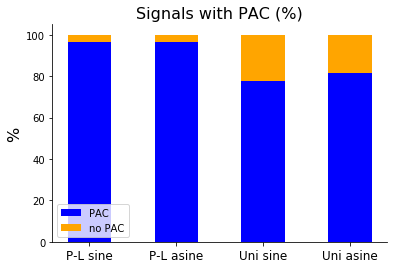

In [250]:
fig, ax = plt.subplots()
idx = np.arange(len(simulation_features_list))
for gr in range(len(simulation_features_list)):
    
    simulation_features = simulation_features_list[gr]

    menMeans = len(simulation_features[simulation_features['pac_presence']=='1']) / len(simulation_features) * 100
    womenMeans = len(simulation_features[simulation_features['pac_presence']=='0']) / len(simulation_features) * 100
    width = 0.5       # the width of the bars: can also be len(x) sequence

    p1 = plt.bar(gr+0.5, menMeans, width, color='blue')
    p2 = plt.bar(gr+0.5, womenMeans, width,
                 bottom=menMeans, color='orange')

plt.ylabel('%', size=16)
plt.title('Signals with PAC (%)', size=16)
plt.xticks(idx +.5, ('P-L sine', 'P-L asine', 'Uni sine', 'Uni asine'), size=12)
plt.legend(['PAC', 'no PAC'], loc='lower left')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

 <div class="alert alert-success">
Good, number of signals with PAC decreases with uniform distribution, while it goes (slightly) up with nonsinusoidal waveforms with uniform distribution
</div>

# Decreasing number of channels with PAC with wider distribution

C:\Users\jaapv\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\jaapv\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Text(0.5, 1.0, 'Less phase-locking decreases % PAC')

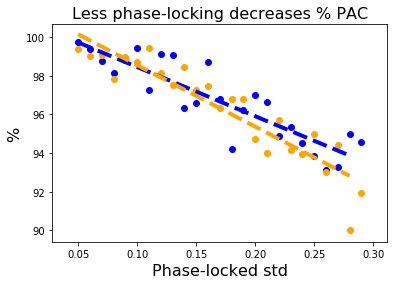

In [251]:
# get percentage PAC in sinusoids
simulation_features = simulation_features_list[0]

prct_pac = [len(simulation_features[simulation_features['pac_presence']=='1'][simulation_features['firing_std'] == (test / 100)]) / \
len(simulation_features[simulation_features['firing_std'] == (test / 100)] *100) * 100 for test in range(5,30)] 

# scatter percentage pac for sinusoids
plt.scatter(np.arange(5,30)/100,prct_pac, color='blue')

# Reg sinusoids
reg1 = linear_model.LinearRegression()
reg1.fit((np.arange(5,30)/100).reshape(-1,1), np.array(prct_pac).reshape(-1,1))
xs = np.arange(min((np.arange(5,30)/100).reshape(-1,1)), max((np.arange(5,30)/100).reshape(-1,1)),0.01)
ys = reg1.intercept_[0] + reg1.coef_[0][0] * xs
plt.plot(xs, ys, '--', color='blue', linewidth=4, alpha=1)

# get percentage pac in nonsinusoids
simulation_features = simulation_features_list[1]

prct_pac = [len(simulation_features[simulation_features['pac_presence']=='1'][simulation_features['firing_std'] == (test / 100)]) / \
len(simulation_features[simulation_features['firing_std'] == (test / 100)]) * 100 for test in range(5,30)] 

# Reg nonsinusoids
reg2 = linear_model.LinearRegression()
reg2.fit((np.arange(5,30)/100).reshape(-1,1), np.array(prct_pac).reshape(-1,1))
xs = np.arange(min((np.arange(5,30)/100).reshape(-1,1)), max((np.arange(5,30)/100).reshape(-1,1)),0.01)
ys = reg2.intercept_[0] + reg2.coef_[0][0] * xs
plt.plot(xs, ys, '--', color='orange', linewidth=4, alpha=1)

plt.scatter(np.arange(5,30)/100,prct_pac, color='orange')
plt.ylabel('%', size=16)
plt.xlabel('Phase-locked std', size=16)
plt.title('Less phase-locking decreases % PAC', size=16)

 <div class="alert alert-success">
Nice its decreasing, as we expected. So far so good.
</div>

# Correlation matrices

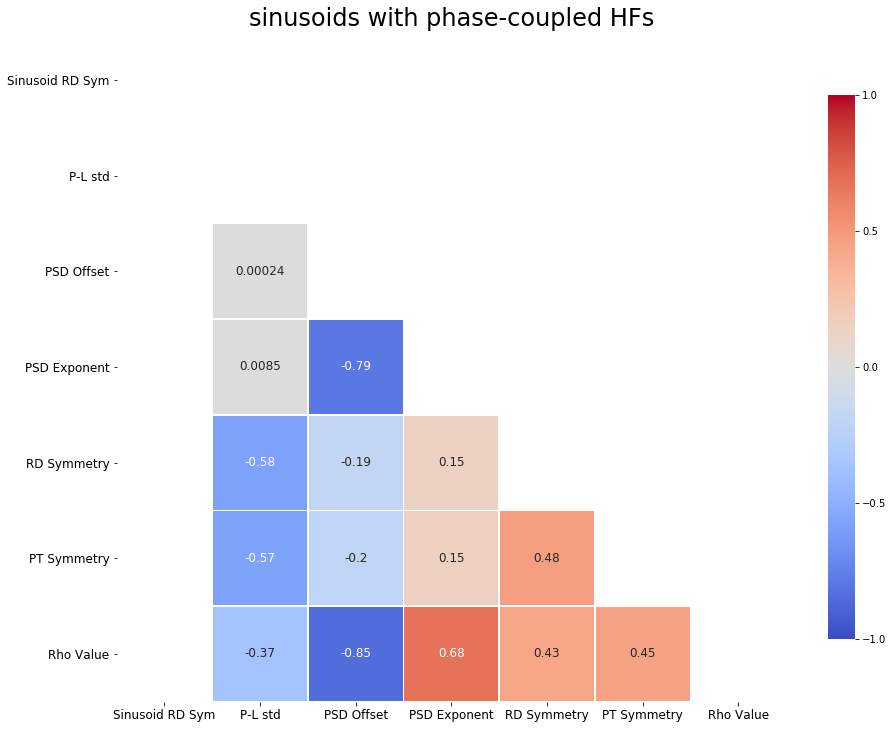

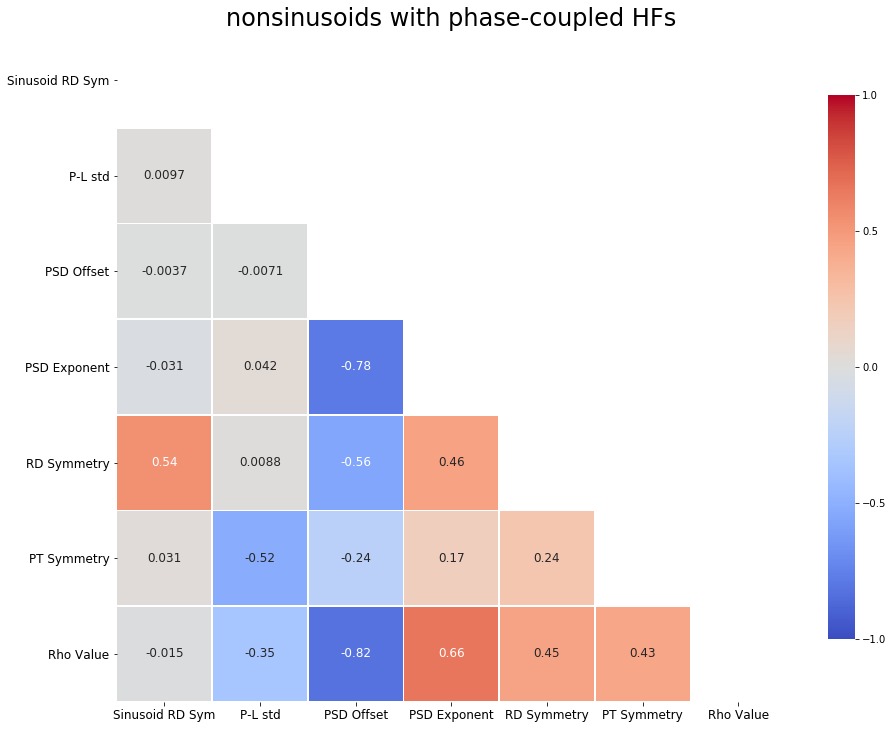

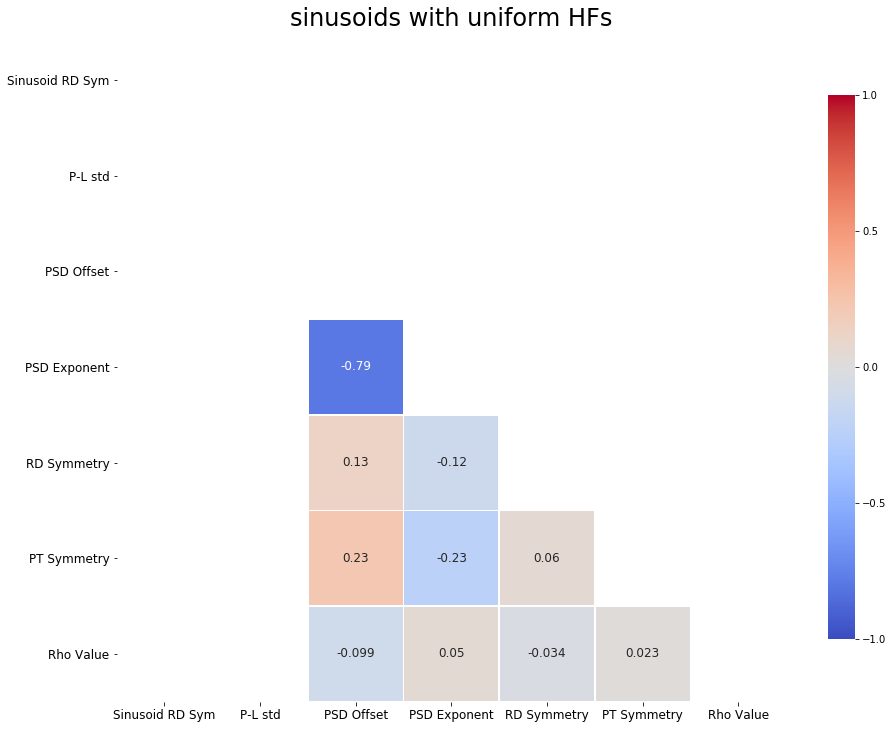

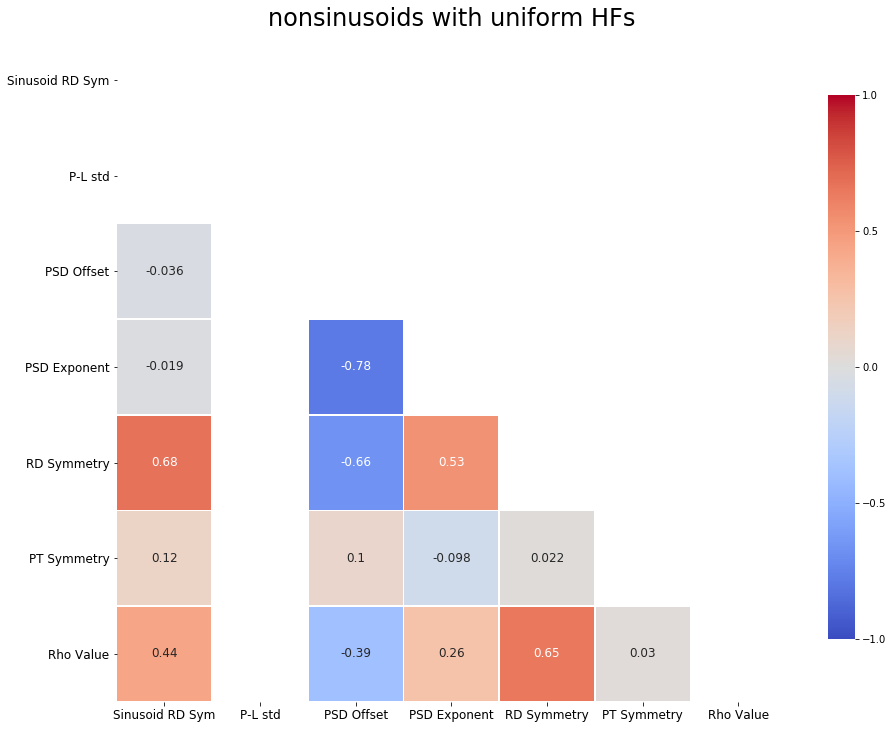

In [254]:
features_name = ['Sinusoid RD Sym', 'P-L std', 'PSD Offset', 'PSD Exponent', 'RD Symmetry', 'PT Symmetry', 'Rho Value']

for gr in range(len(simulation_features_list)): 
    
    simulation_features = simulation_features_list[gr]
    
    #### first create new dataframe with only the features we want to plot
    corr_features_df = simulation_features[['asine_rdsym', 'firing_std',
           'offset', 'exp', 'rdsym_abs', 'ptsym_abs', 'pac_rhos']].copy()

    corr_matrix = corr_features_df.corr()

    mask = np.zeros_like(corr_matrix, dtype=np.bool)
    mask[np.triu_indices_from(mask)]= True

    f, ax = plt.subplots(figsize=(15, 20))

    heatmap = sns.heatmap(corr_matrix,
                          mask = mask,
                          square = True,
                          linewidths = .5,
                          cmap = 'coolwarm',
                          cbar_kws = {'shrink': .5,
                                    'ticks' : [-1, -.5, 0, 0.5, 1]},
                          vmin = -1,
                          vmax = 1,
                          annot = True,
                          annot_kws = {'size': 12})

    #add the column names as labels
    ax.set_yticklabels(features_name, rotation = 0, size=12)
    ax.set_xticklabels(features_name, size=12)

    sns.set_style({'xtick.bottom': True}, {'ytick.left': True})
    ax.set_title(group_name[gr], size=24)

 <div class="alert alert-success">
Good stuff! With HF activity distributions, in both nonsinusoid and sinusoid condition, shape, firing std, and aperiodic component are correlated with PAC. In the sinusoid & uniform group these correlations are not there, as we expect. While in the nonsinusoid & uniform these correlations appear again (apart from ptsym, we also do not manipulate this). So: it seems that firing distribution creates shape & PAC, but also uniform firing distribution with already shapey waveform creates PAC.
</div>

# HF activity distributions affect PAC & shape

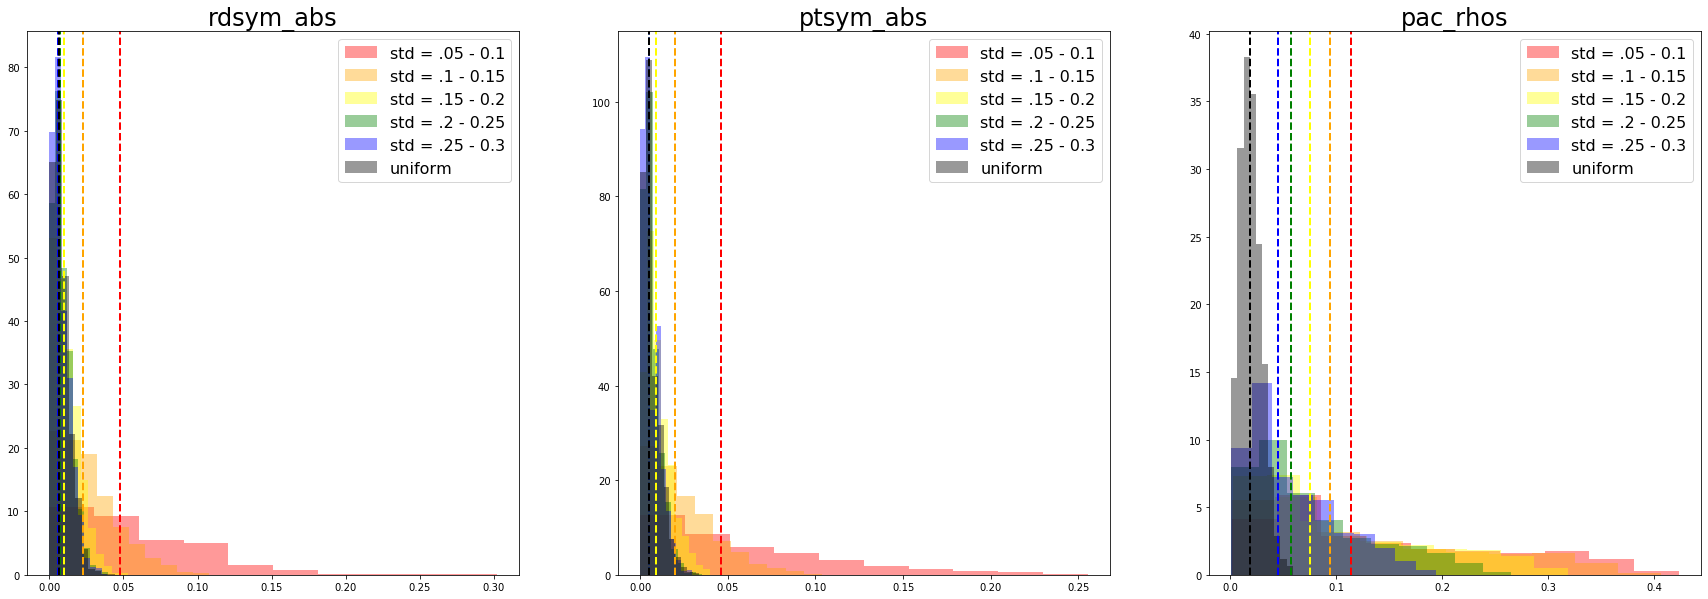

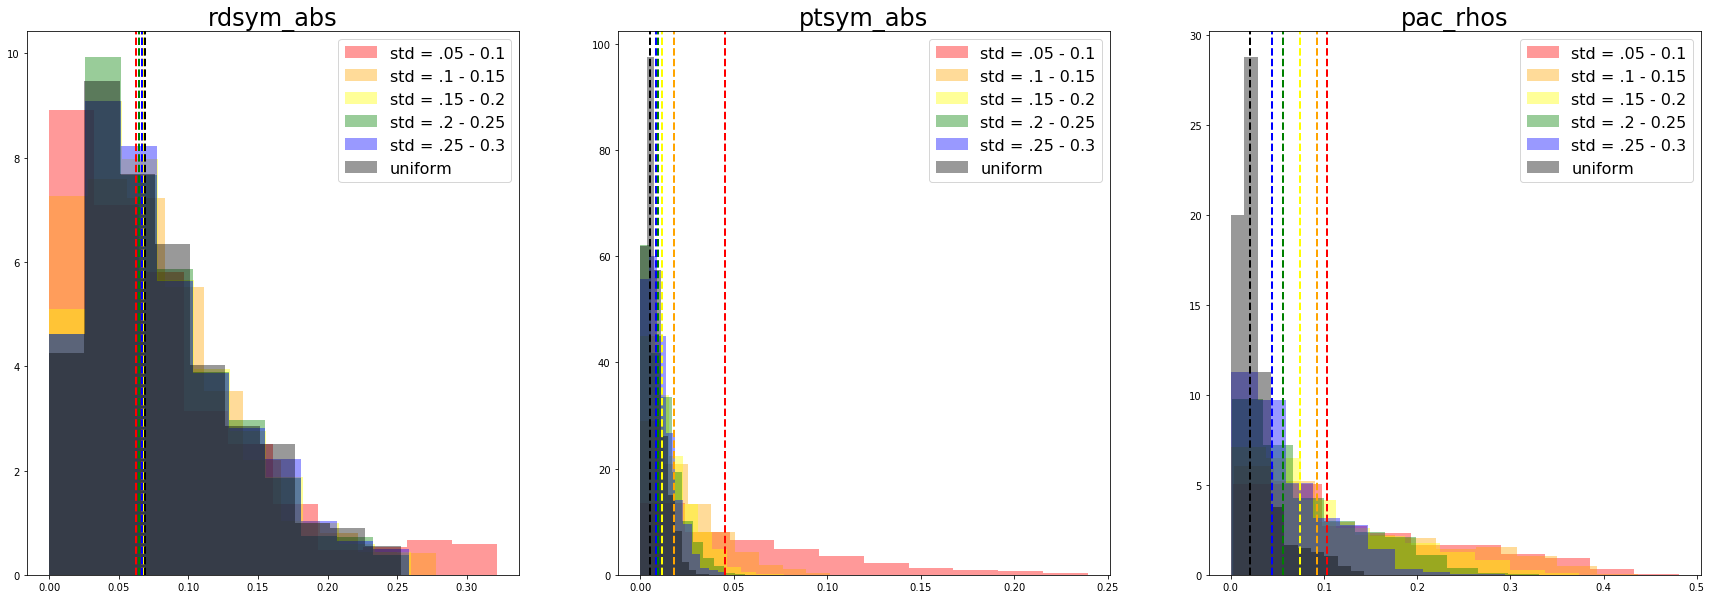

In [199]:
# manually set which columns you want to plot
hist_list = ['rdsym_abs', 'ptsym_abs', 'pac_rhos']
std_list = np.arange(5,35,5) / 100
label_name = ['std = .05 - 0.1', 'std = .1 - 0.15', 'std = .15 - 0.2', 'std = .2 - 0.25', 'std = .25 - 0.3']
color_name = ['red', 'orange', 'yellow', 'green', 'blue']

for gr in range(2):
    
    simulation_features = sine_or_asine[gr]
    
    kwargs = dict(alpha=0.4, density=True, bins=10)

    plt.figure(figsize=(30,10))
    for ii in range(len(hist_list)):  

        # subplots 3x3
        plt.subplot(1,3,ii+1)
        #xticks([]), yticks([])
        
        for sd in range(len(std_list) -1):
        
            # for each distribution group
            plt.hist(simulation_features[(simulation_features['firing_std']>= std_list[sd]) & 
                                         (simulation_features['firing_std']<std_list[sd+1])][hist_list[ii]],
                                         color=color_name[sd], label = label_name[sd], **kwargs)

            plt.axvline(np.median(simulation_features[(simulation_features['firing_std']>= std_list[sd]) &
                                                      (simulation_features['firing_std']<std_list[sd+1])][hist_list[ii]]), 
                                                     color=color_name[sd], linestyle='dashed', linewidth=2)
        
        # uniform
        plt.hist(simulation_features[simulation_features['firing_std']== 1][hist_list[ii]], 
         color='black', label = 'uniform', **kwargs)    
        
        plt.axvline(np.median(simulation_features[simulation_features['firing_std']== 1][hist_list[ii]]), 
            color='black', linestyle='dashed', linewidth=2)
        
#         # print statistics
#         stats = f_oneway(features_df[features_df['Clusters']==0][features_df.columns[jj]],
#                 features_df[features_df['Clusters']==1][features_df.columns[jj]], 
#                 features_df[features_df['Clusters']==13][features_df.columns[jj]]) 

        # plt.title(features_df.columns[jj] + '  ' + 'pval = ' + str(stats[1]), size=16)
        plt.legend(fontsize=16)
        plt.title(hist_list[ii], size=24)

 <div class="alert alert-success">
The first row represents sinusoids + phase-locked HF activity, the second row nonsinusoids (with altered rdsym). We see that more phase-locked HF activity gives more asymmetry and more PAC. In the group with nonsinusoids the rdsym is evenly distributed, something we manipulated, but still induces more ptsym, and also increasing PAC. Have to test this: might be that the blue (highly phase-locked) distribution is wider for rdsym in nonsinusoids. If so, this is because sometimes the HF activity perfectly lines up, or is opposity, of the induced asymmetry, so strenghtens the effect. 
</div>

# other way of visualizing last graph

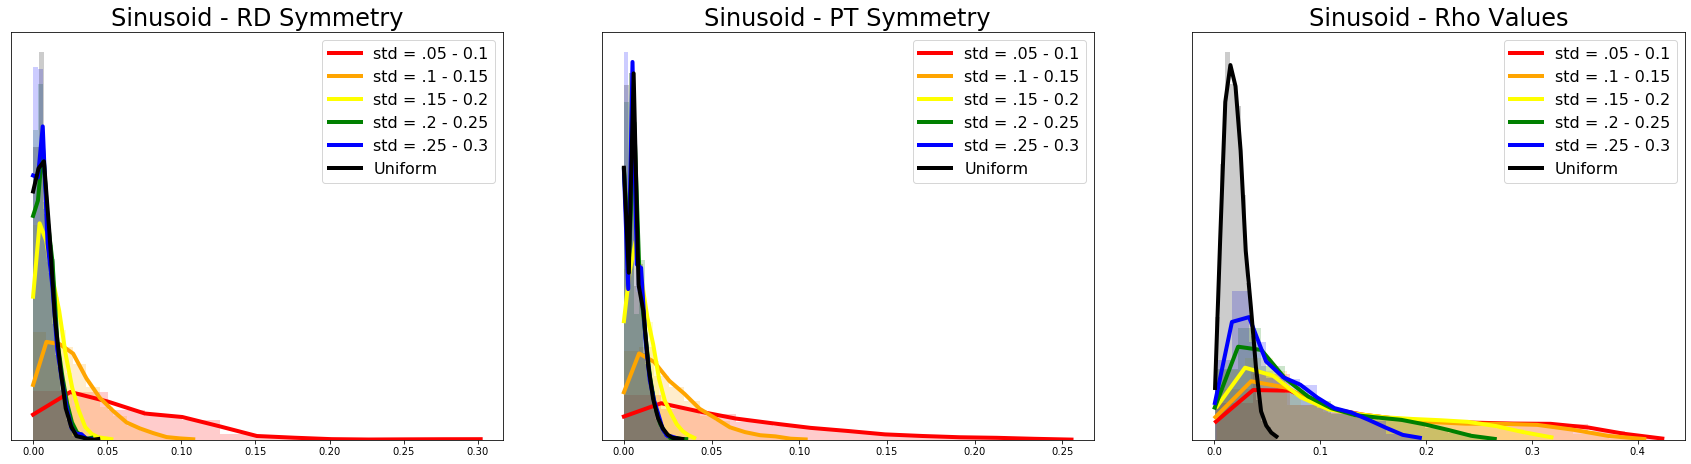

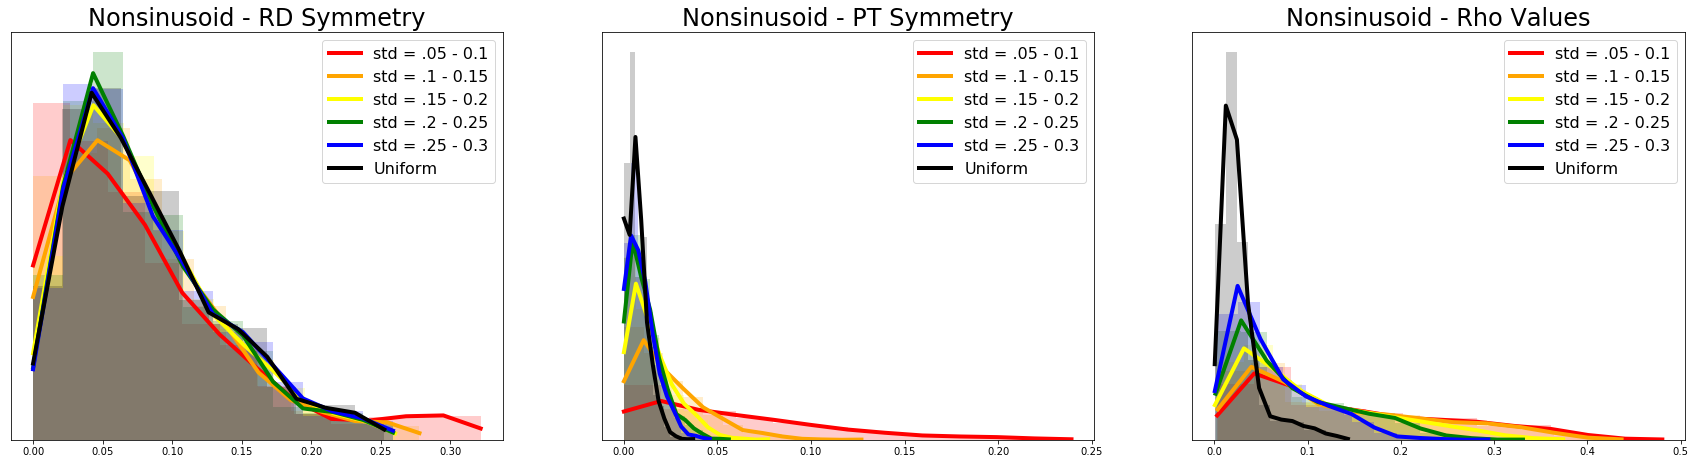

In [201]:
# manually set which columns you want to plot
hist_list = ['rdsym_abs', 'ptsym_abs', 'pac_rhos']
feature_names = ['RD Symmetry', 'PT Symmetry', 'Rho Values']
std_list = np.arange(5,35,5) / 100
label_name = ['std = .05 - 0.1', 'std = .1 - 0.15', 'std = .15 - 0.2', 'std = .2 - 0.25', 'std = .25 - 0.3']
color_name = ['red', 'orange', 'yellow', 'green', 'blue']
sine_name = ['Sinusoid - ', 'Nonsinusoid - ']

for gr in range(2):
    
    simulation_features = sine_or_asine[gr]
    
    kwargs = dict(alpha=0.2, density=True, bins=12)

    plt.figure(figsize=(30,7.5))
    for ii in range(len(hist_list)):  

        for sd in range(len(std_list) -1):
            
            # subplots 3x3
            plt.subplot(1,3,ii+1)
            #xticks([]), yticks([])

            n, x, _ = plt.hist(simulation_features[(simulation_features['firing_std']>= std_list[sd]) & 
                                         (simulation_features['firing_std']<std_list[sd+1])][hist_list[ii]],
                                         color=color_name[sd], label = label_name[sd], **kwargs)
            
            density = stats.gaussian_kde(
                simulation_features[(simulation_features['firing_std']>= std_list[sd]) & 
                                    (simulation_features['firing_std']<std_list[sd+1])][hist_list[ii]])

            plt.plot(x, density(x), color=color_name[sd], linewidth=4)
            
        # for uniform distribution
        n, x, _ = plt.hist(simulation_features[simulation_features['firing_std']== 1][hist_list[ii]], 
         color='black', label = 'uniform', **kwargs)
        
        density = stats.gaussian_kde(
            simulation_features[simulation_features['firing_std']== 1][hist_list[ii]])
        
        plt.plot(x, density(x), color='black', linewidth=4)
            
#         # print statistics
#         stats = f_oneway(features_df[features_df['Clusters']==0][features_df.columns[jj]],
#                 features_df[features_df['Clusters']==1][features_df.columns[jj]], 
#                 features_df[features_df['Clusters']==13][features_df.columns[jj]]) 

        # plt.title(features_df.columns[jj] + '  ' + 'pval = ' + str(stats[1]), size=16)
        plt.legend(['std = .05 - 0.1', 'std = .1 - 0.15', 'std = .15 - 0.2', 'std = .2 - 0.25', 'std = .25 - 0.3', 'Uniform'],fontsize=16)
        plt.title(sine_name[gr] + feature_names[ii], size=24)
        plt.yticks([])

# Regressions on phase-locked HF activity

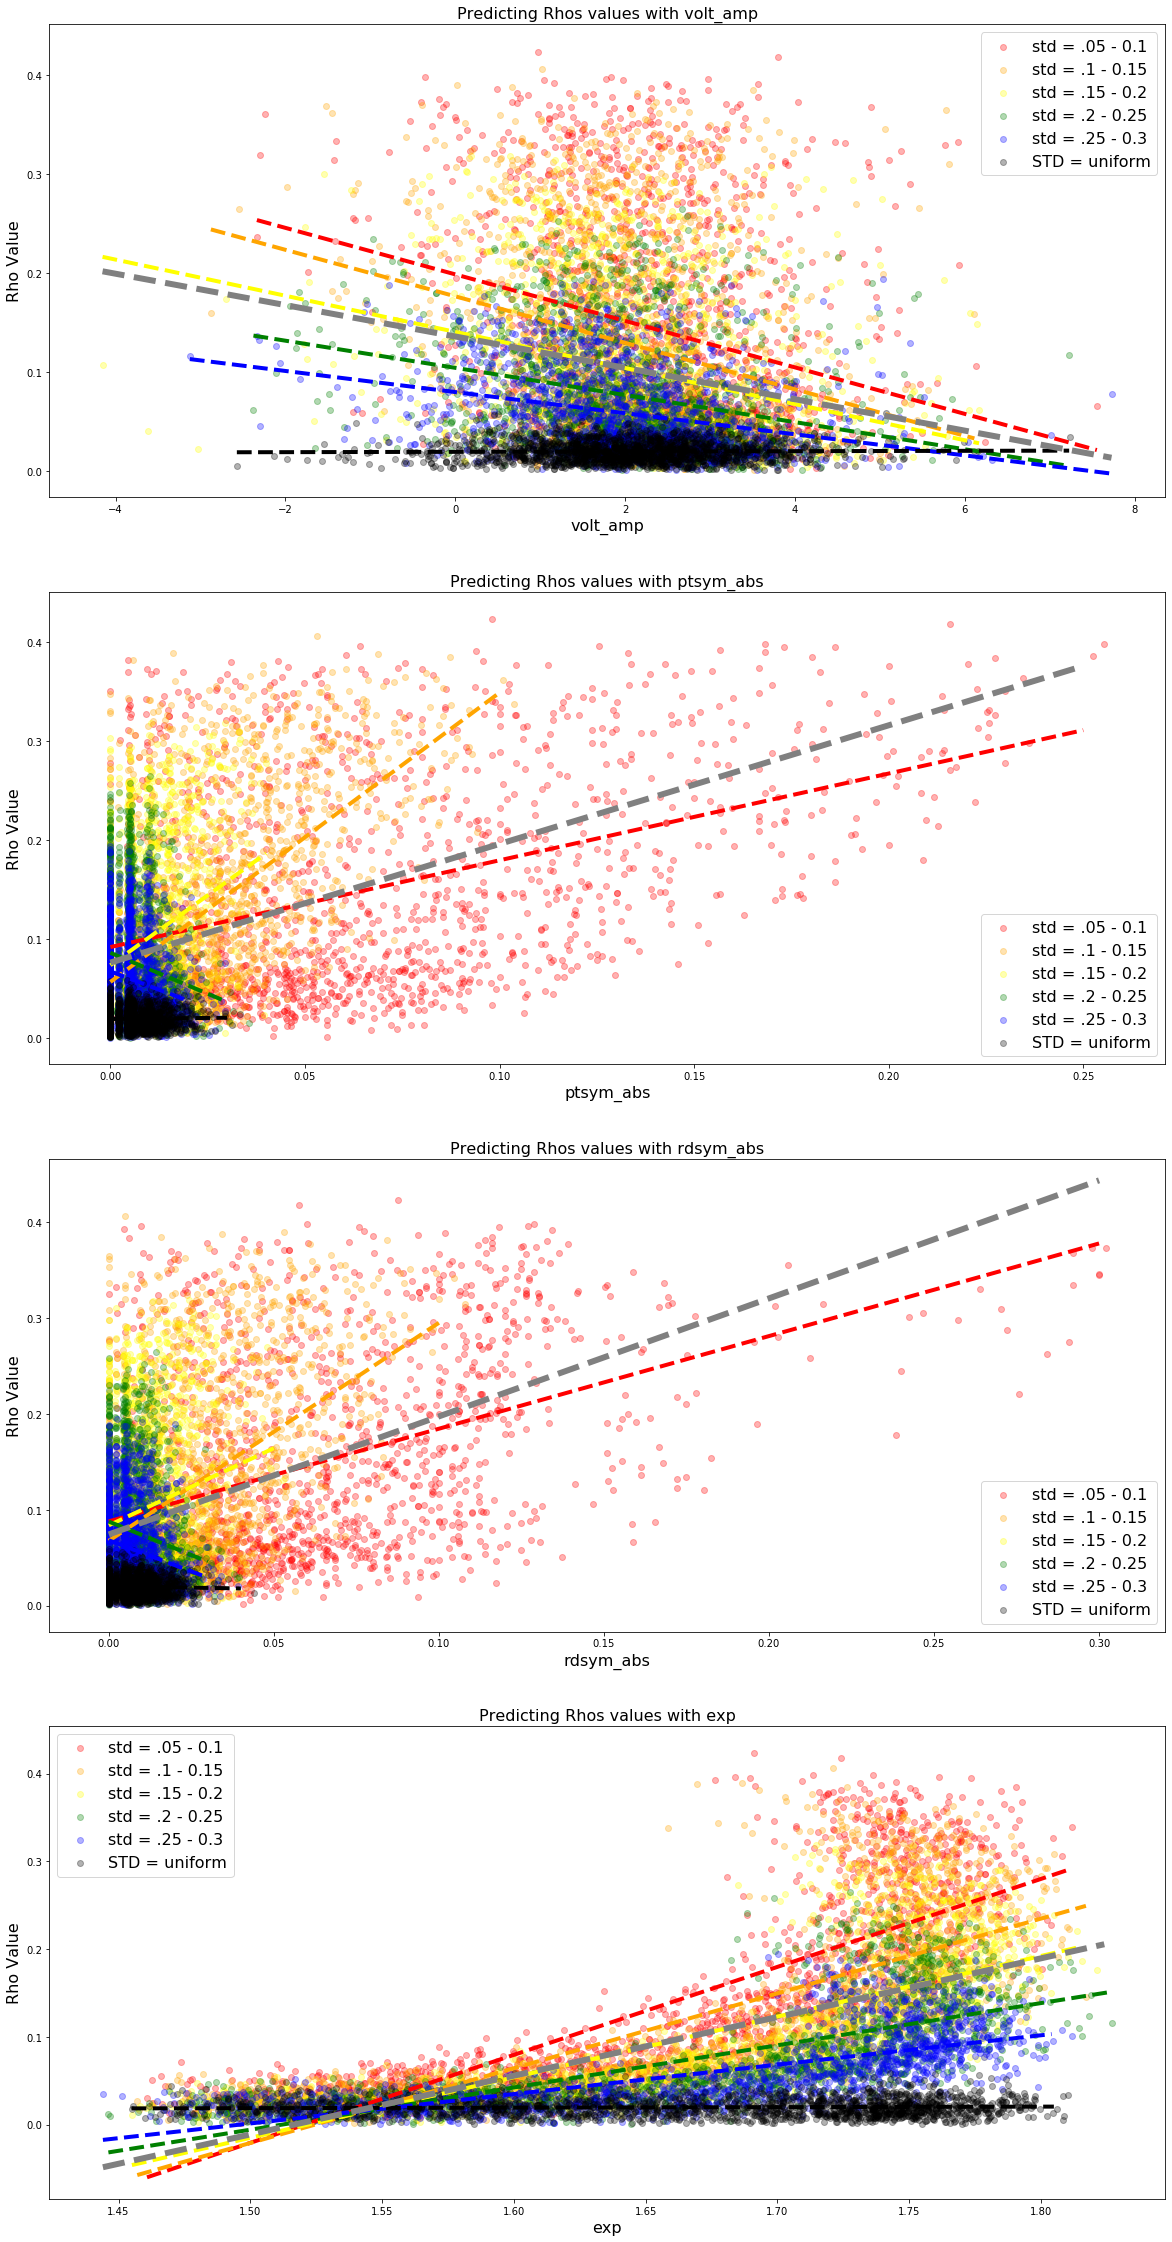

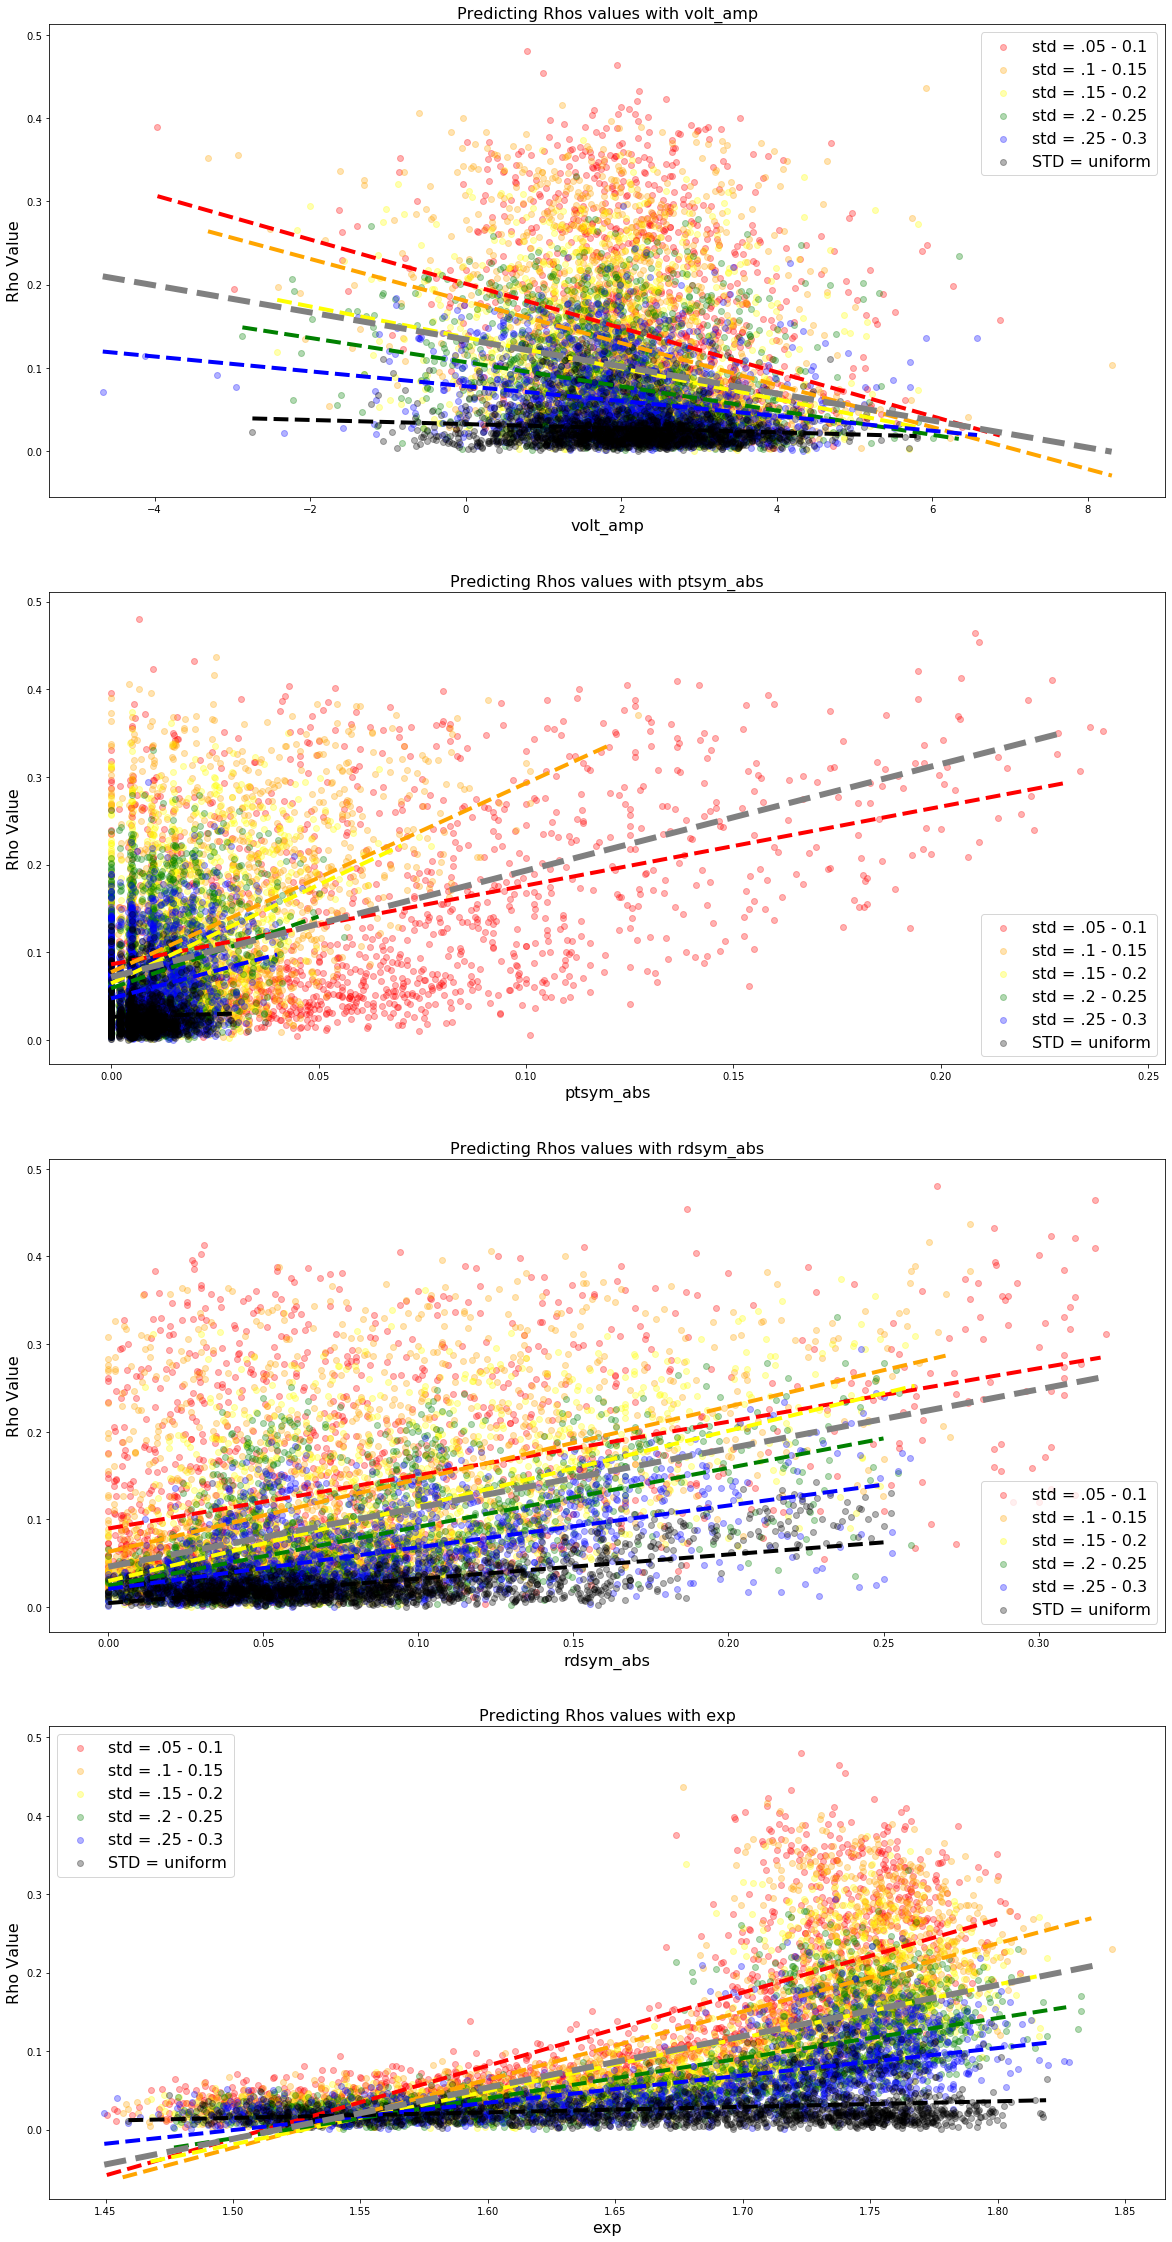

In [204]:
feature = ['volt_amp', 'ptsym_abs', 'rdsym_abs', 'exp']
std_list = np.arange(5,35,5) / 100
label_name = ['std = .05 - 0.1', 'std = .1 - 0.15', 'std = .15 - 0.2', 'std = .2 - 0.25', 'std = .25 - 0.3']
color_name = ['red', 'orange', 'yellow', 'green', 'blue']

for gr in range(2):
    
    simulation_features = sine_or_asine[gr]

    plt.figure(figsize=(20,40))
    for ii in range(len(feature)):  

        plt.subplot(4,1,ii+1)
        
        for sd in range(len(std_list)-1):
            
            # reshape rho values
            pac_rhos_std = simulation_features[(simulation_features['firing_std']>= std_list[sd]) &
                                                (simulation_features['firing_std']< std_list[sd+1])]['pac_rhos'].values.reshape(-1,1)
                     
            
            # reshape other feature
            feature_std = simulation_features[(simulation_features['firing_std']>= std_list[sd]) &
                                               (simulation_features['firing_std']< std_list[sd+1])][feature[ii]].values.reshape(-1,1)



            # STD scatter
            plt.scatter(simulation_features[(simulation_features['firing_std']>= std_list[sd]) &
                                            (simulation_features['firing_std']< std_list[sd+1])][feature[ii]],
                        simulation_features[(simulation_features['firing_std']>= std_list[sd]) &
                                            (simulation_features['firing_std']< std_list[sd+1])]['pac_rhos'],
                       color=color_name[sd], alpha =.3, label=label_name[sd])


            # Reg STD 
            reg1 = linear_model.LinearRegression()
            reg1.fit(feature_std, pac_rhos_std)
            xs = np.arange(min(feature_std), max(feature_std),0.01)
            ys = reg1.intercept_[0] + reg1.coef_[0][0] * xs
            plt.plot(xs, ys, '--', color=color_name[sd], linewidth=4, alpha=1)

        # shape uni rhos and feature
        pac_rhos_uni = simulation_features[simulation_features['firing_std']== 1]['pac_rhos'].values.reshape(-1,1)
        feature_uni = simulation_features[simulation_features['firing_std']== 1][feature[ii]].values.reshape(-1,1)

        # Uniform scatter
        plt.scatter(simulation_features[simulation_features['firing_std']==1][feature[ii]],
                    simulation_features[simulation_features['firing_std']==1]['pac_rhos'],
                   color='black', alpha =.3, label='STD = uniform')

        # Reg Uni
        reg2 = linear_model.LinearRegression()
        reg2.fit(feature_uni, pac_rhos_uni)
        xs = np.arange(min(feature_uni), max(feature_uni),0.01)
        ys = reg2.intercept_[0] + reg2.coef_[0][0] * xs
        plt.plot(xs, ys, '--', color='black', linewidth=4, alpha=1)
        
        # full STD model regression
        pac_rhos_std_full = simulation_features[simulation_features['firing_std']!= 1]['pac_rhos'].values.reshape(-1,1)
        feature_std_full = simulation_features[simulation_features['firing_std']!= 1][feature[ii]].values.reshape(-1,1)
        
        reg3 = linear_model.LinearRegression()
        reg3.fit(feature_std_full, pac_rhos_std_full)
        xs = np.arange(min(feature_std_full), max(feature_std_full),0.01)
        ys = reg3.intercept_[0] + reg3.coef_[0][0] * xs
        plt.plot(xs, ys, '--', color='grey', linewidth=6, alpha=1)
        

        plt.title('Predicting Rhos values with ' + feature[ii], fontsize=16)
        plt.xlabel(feature[ii], fontsize=16)
        plt.ylabel('Rho Value', fontsize=16)
        plt.legend(fontsize=16)

 <div class="alert alert-success">
More great results. The 4 regressions represents sinusoids + phase-locked HF activity, the latter 4 nonsinusoids (with altered rdsym) + phase-locked HF activity. Everything seems very consistent. Only strange thing is a decreasing amplitude with increasing Rho values. However I think this can be explained. In these simulations, PAC gets higher (and shape more asymmetric) when the HF activity lines up with a rising or decreasing phase of the 10 Hz frequency. However, amplitude gets higher when HF activity aligns with the peak of a signal, while this gives not more asymmetry and not more PAC. Amplitude is still useful, because in real data, amplitude also reflects sharp deflections which increase PAC. In these simulations we don't have these 'artifactual' deflections. Furthermore, we see a relationship between uniform distribution and rho value in only one plot, which is in RD symmetry in the nonsinusoid condition, which we induced ourselfs in these simulations. Also, a very consistent relationship between Rho value and Exponent. I think this shows that when there is more slope, so less power in HFs, the added HFs have much more effect, and thus increase PAC and asymmetry  
</div>

 <div class="alert alert-success">
Possible other analysis: 1) do more analysis on the differences between sinusoids + phase-locked distribution, and nonsinusoids + uniform distribution 2) split exponent up in two groups: lower and higher, to more clearly see effect of exponent, also on other features such as asymmetry. 3) differences between sinusoids and nonsinusoids in uniform distributions

</div>

# Exponent regression for in presentation

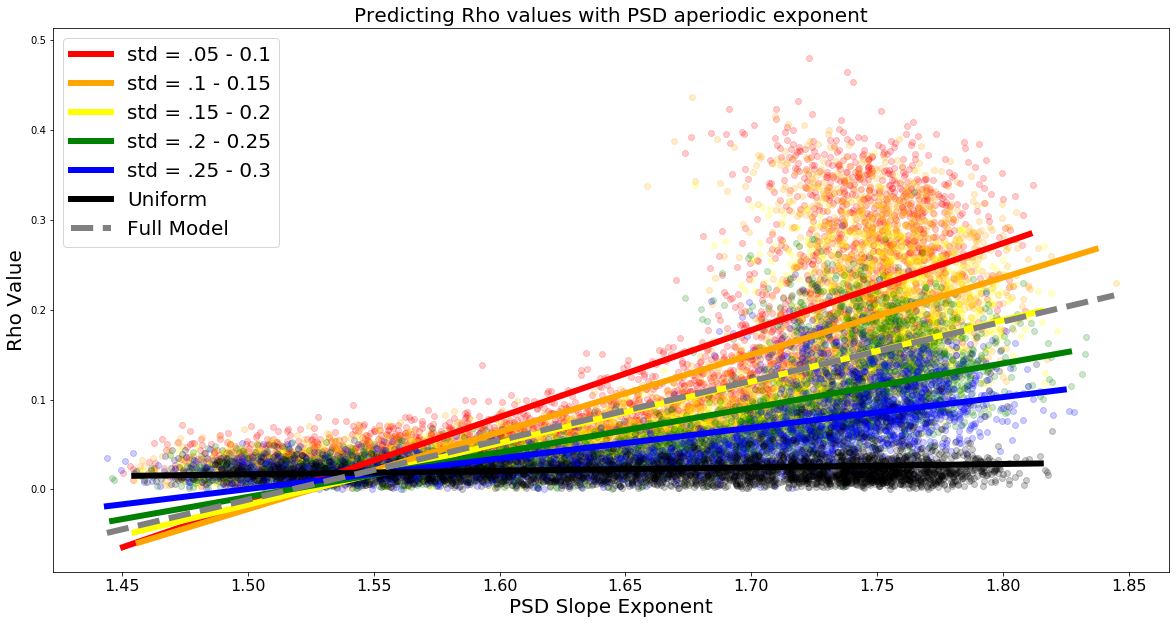

In [257]:
feature = ['exp']
std_list = np.arange(5,35,5) / 100
label_name = ['std = .05 - 0.1', 'std = .1 - 0.15', 'std = .15 - 0.2', 'std = .2 - 0.25', 'std = .25 - 0.3']
color_name = ['red', 'orange', 'yellow', 'green', 'blue']

for gr in range(1):
    
    simulation_features = simulation_features_full

    plt.figure(figsize=(20,10))
    for ii in range(len(feature)):  

        plt.subplot(1,1,ii+1)
        
        for sd in range(len(std_list)-1):
            
            # reshape rho values
            pac_rhos_std = simulation_features[(simulation_features['firing_std']>= std_list[sd]) &
                                                (simulation_features['firing_std']< std_list[sd+1])]['pac_rhos'].values.reshape(-1,1)
                     
            
            # reshape other feature
            feature_std = simulation_features[(simulation_features['firing_std']>= std_list[sd]) &
                                               (simulation_features['firing_std']< std_list[sd+1])][feature[ii]].values.reshape(-1,1)



            # STD scatter
            plt.scatter(simulation_features[(simulation_features['firing_std']>= std_list[sd]) &
                                            (simulation_features['firing_std']< std_list[sd+1])][feature[ii]],
                        simulation_features[(simulation_features['firing_std']>= std_list[sd]) &
                                            (simulation_features['firing_std']< std_list[sd+1])]['pac_rhos'],
                       color=color_name[sd], alpha =.2, label=label_name[sd])


            # Reg STD 
            reg1 = linear_model.LinearRegression()
            reg1.fit(feature_std, pac_rhos_std)
            xs = np.arange(min(feature_std), max(feature_std),0.01)
            ys = reg1.intercept_[0] + reg1.coef_[0][0] * xs
            plt.plot(xs, ys, '-', color=color_name[sd], linewidth=6, alpha=1)

        # shape uni rhos and feature
        pac_rhos_uni = simulation_features[simulation_features['firing_std']== 1]['pac_rhos'].values.reshape(-1,1)
        feature_uni = simulation_features[simulation_features['firing_std']== 1][feature[ii]].values.reshape(-1,1)

        # Uniform scatter
        plt.scatter(simulation_features[simulation_features['firing_std']==1][feature[ii]],
                    simulation_features[simulation_features['firing_std']==1]['pac_rhos'],
                   color='black', alpha =.2, label='STD = uniform')

        # Reg Uni
        reg2 = linear_model.LinearRegression()
        reg2.fit(feature_uni, pac_rhos_uni)
        xs = np.arange(min(feature_uni), max(feature_uni),0.01)
        ys = reg2.intercept_[0] + reg2.coef_[0][0] * xs
        plt.plot(xs, ys, '-', color='black', linewidth=6, alpha=1)
        
        # full STD model regression
        pac_rhos_std_full = simulation_features[simulation_features['firing_std']!= 1]['pac_rhos'].values.reshape(-1,1)
        feature_std_full = simulation_features[simulation_features['firing_std']!= 1][feature[ii]].values.reshape(-1,1)
        
        reg3 = linear_model.LinearRegression()
        reg3.fit(feature_std_full, pac_rhos_std_full)
        xs = np.arange(min(feature_std_full), max(feature_std_full),0.01)
        ys = reg3.intercept_[0] + reg3.coef_[0][0] * xs
        plt.plot(xs, ys, '--', color='grey', linewidth=6, alpha=1)
        

        plt.title('Predicting Rho values with PSD aperiodic exponent', fontsize=20)
        plt.xlabel('PSD Slope Exponent', fontsize=20)
        plt.ylabel('Rho Value', fontsize=20)
        plt.xticks(size=16)
        plt.xticks(size=16)
        plt.legend(['std = .05 - 0.1', 'std = .1 - 0.15', 'std = .15 - 0.2', 'std = .2 - 0.25', 'std = .25 - 0.3', 'Uniform', 'Full Model'],fontsize=20)


# Uniform HF activity regression on Rho value

In [223]:
range(2,len(simulation_features_list))

range(2, 4)

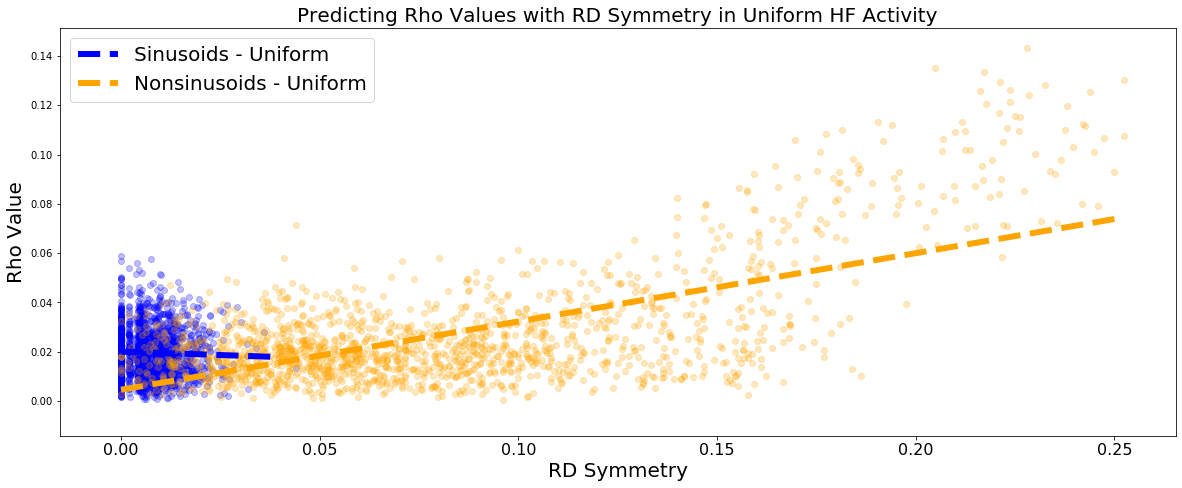

In [228]:
color_gr = ['red', 'green', 'blue', 'orange']

plt.figure(figsize=(20,7.5))

for gr in range(2,len(simulation_features_list)): 
    
    simulation_features = simulation_features_list[gr]
    
   
    kwargs = dict(alpha=0.2, density=True, bins=12)
    # shape uni rhos and feature
    
    pac_rhos_uni = simulation_features['pac_rhos'].values.reshape(-1,1)
    feature_uni = simulation_features['rdsym_abs'].values.reshape(-1,1)

    # Uniform scatter
    plt.scatter(simulation_features['rdsym_abs'],
                simulation_features['pac_rhos'],
               color=color_gr[gr], alpha =.25)

    # Reg Uni
    reg2 = linear_model.LinearRegression()
    reg2.fit(feature_uni, pac_rhos_uni)
    xs = np.arange(min(feature_uni), max(feature_uni),0.01)
    ys = reg2.intercept_[0] + reg2.coef_[0][0] * xs
    plt.plot(xs, ys, '--', color=color_gr[gr], linewidth=6, alpha=1)

    plt.title('Predicting Rho Values with RD Symmetry in Uniform HF Activity', fontsize=20)
    plt.xlabel('RD Symmetry', fontsize=20)
    plt.ylabel('Rho Value', fontsize=20)
    plt.xticks(size=16)
    plt.xticks(size=16)
    plt.legend(['Sinusoids - Uniform', 'Nonsinusoids - Uniform'],fontsize=20)
